2025-03-12 01:14:45.794170: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-12 01:14:45.794758: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-12 01:14:45.796745: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-12 01:14:45.803537: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741716885.813309  126403 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741716885.81

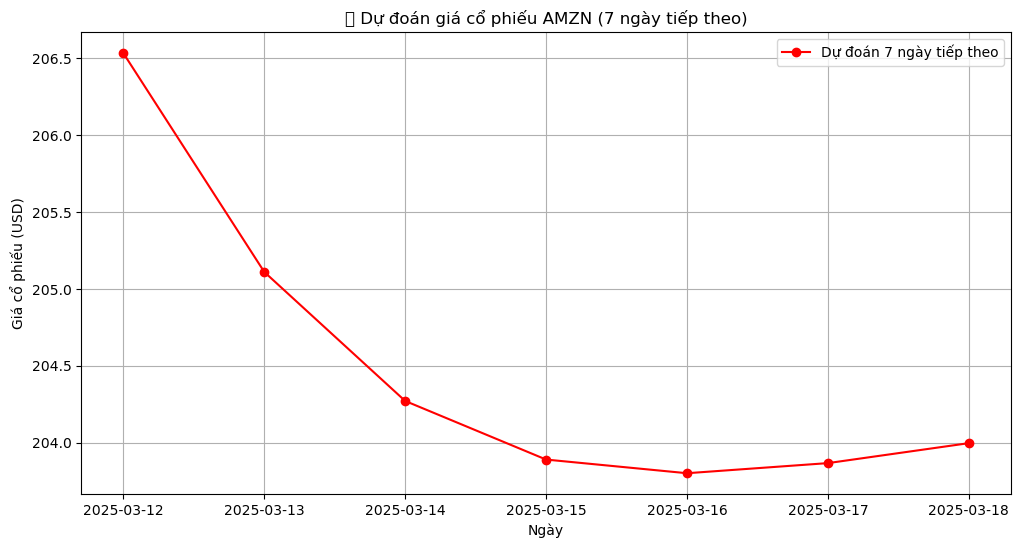

In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras

# 🟢 BƯỚC 1: TẢI DỮ LIỆU 45 NGÀY CUỐI
Macophieu = "AMZN"  # Chọn mã cổ phiếu
prop = "Close"  # Chọn giá trị cần dự đoán
end = "2025-03-10"

tickerData = yf.Ticker(Macophieu)
tickerDf = tickerData.history(period="60d", end=end)  # Lấy dư 60 ngày để đảm bảo đủ 45 ngày
data = tickerDf[[prop]].values  # Chỉ lấy cột giá trị cần thiết

# 🟢 BƯỚC 2: TIỀN XỬ LÝ DỮ LIỆU
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)  # Chuẩn hóa dữ liệu

# Lấy 45 ngày cuối cùng làm đầu vào
last_input = data_scaled[-45:]

# Kiểm tra dữ liệu có đủ không
if len(last_input) < 45:
    raise ValueError("Dữ liệu không đủ 45 ngày để dự đoán.")

# 🟢 BƯỚC 3: LOAD MÔ HÌNH ĐÃ TRAIN
try:
    model = keras.models.load_model("AMZN_Close.keras")  # Thay đường dẫn model phù hợp
except Exception as e:
    raise RuntimeError(f"Lỗi khi load model: {e}")

# 🟢 BƯỚC 4: DỰ ĐOÁN 7 NGÀY TIẾP THEO
last_input = np.reshape(last_input, (1, 45, 1))  # Chuyển về định dạng phù hợp với LSTM
predicted_prices = []

for _ in range(7):  # Dự đoán 7 ngày tiếp theo
    pred = model.predict(last_input, verbose=0)[0, 0]
    predicted_prices.append(pred)

    # Cập nhật đầu vào cho lần dự đoán tiếp theo
    last_input = np.append(last_input[:, 1:, :], [[[pred]]], axis=1)

# 🟢 BƯỚC 5: CHUYỂN DỰ ĐOÁN VỀ GIÁ THỰC TẾ
predicted_prices_actual = scaler.inverse_transform(np.array(predicted_prices).reshape(-1, 1))

# 🟢 BƯỚC 6: VẼ BIỂU ĐỒ
plt.figure(figsize=(12, 6))
plt.plot(pd.date_range(start=tickerDf.index[-1], periods=8, freq="D")[1:], predicted_prices_actual, 
         label="Dự đoán 7 ngày tiếp theo", color="red", marker="o")

plt.xlabel("Ngày")
plt.ylabel("Giá cổ phiếu (USD)")
plt.title(f"📈 Dự đoán giá cổ phiếu {Macophieu} (7 ngày tiếp theo)")
plt.legend()
plt.grid()
plt.show()
